In [2]:
import numpy as np
import torchvision
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import random
from collections import Counter
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna
from torchvision.transforms import functional as F
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Set random seed for reproducibility

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

### Part I: Combining digits, splitting dataset, checking statistical measures

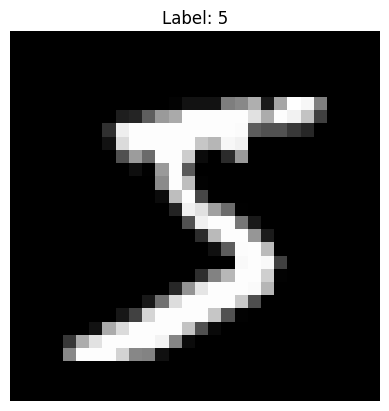

In [6]:
image0, label0 = full_dataset[0]

# plotting the first tensor object

image_np = image0.numpy().squeeze()
plt.imshow(image_np, cmap='gray')
plt.title(f'Label: {label0}')
plt.axis('off')
plt.show()

In [7]:
def combine_images(data, combination_type, label_type = 'sum'):
    combined_images = []
    combined_labels = []
    
    if combination_type == 'random':
        indices = list(range(len(data)))
        random.shuffle(indices)
        for i in range(0, len(indices) - 1, 2):
            img1, label1 = data[indices[i]]
            img2, label2 = data[indices[i+1]]
            
            combined_img = torch.cat((img1, img2), dim=1)
            combined_img_flipped = torch.cat((img2, img1), dim=1)
            
            combined_lab = label1 + label2
            
            combined_images.append(combined_img)
            combined_images.append(combined_img_flipped)
            combined_labels.append(combined_lab)
            combined_labels.append(combined_lab)
            
    return combined_images, combined_labels
        

In [8]:
images, labels = combine_images(full_dataset, 'random')

In [9]:
len(images), len(labels)

(70000, 70000)

In [10]:
def show_digit(image_no, images_dataset, label_dataset):
    image_np = images_dataset[image_no].numpy().squeeze()
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Label {label_dataset[image_no]}')
    plt.axis('off')
    plt.show()

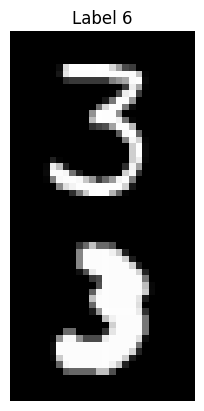

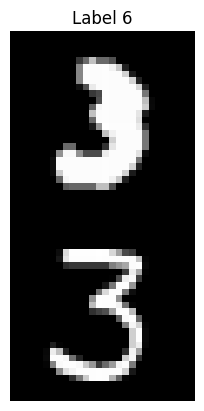

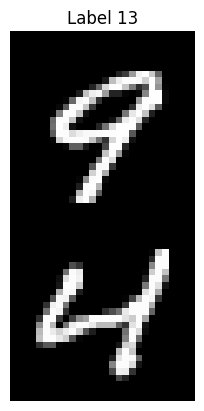

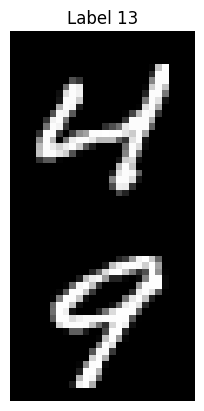

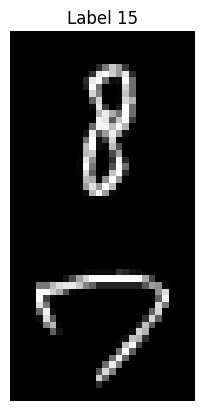

In [11]:
# Plotting the first 10 pairs of numbers with labels

for i in range(0,5):   
    show_digit(i, images, labels)

In [12]:
def split_dataset(image_dataset, label_dataset, train_ratio = 0.6, val_ratio=0.2):
    train_no = int(len(image_dataset)*train_ratio)
    val_no = train_no + int(len(image_dataset)*val_ratio)
    
    train_images = image_dataset[:train_no]
    train_labels = label_dataset[:train_no]
    
    val_images = image_dataset[train_no:val_no]
    val_labels = label_dataset[train_no:val_no]
    
    test_images = image_dataset[val_no:]
    test_labels = label_dataset[val_no:]
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)
    
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = split_dataset(images, labels)


In [13]:
len(train_images)

42000

In [16]:
# train_images_tensor = torch.stack(train_images)
# train_labels_tensor = torch.tensor(train_labels)

# val_images_tensor = torch.stack(val_images)
# val_labels_tensor = torch.tensor(val_labels)

# test_images_tensor = torch.stack(test_images)
# test_labels_tensor = torch.tensor(test_labels)

In [14]:
# Ensuring statistical properties are guaranteed

digit_counts = Counter(label for _, label in full_dataset)
print("Original digit frequencies:", digit_counts)

combined_label_counts = Counter(labels)
print("Combined label frequencies:", combined_label_counts)


train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
test_label_counts = Counter(test_labels)

print("Training label distribution:", train_label_counts)
print("Validation label distribution:", val_label_counts)
print("Test label distribution:", test_label_counts)

Original digit frequencies: Counter({1: 7877, 7: 7293, 3: 7141, 2: 6990, 9: 6958, 0: 6903, 6: 6876, 8: 6825, 4: 6824, 5: 6313})
Combined label frequencies: Counter({9: 7026, 10: 6270, 8: 6248, 7: 5580, 11: 5308, 6: 5042, 12: 4802, 5: 4258, 13: 4058, 4: 3628, 14: 3338, 3: 3002, 15: 2758, 16: 2238, 2: 2228, 1: 1572, 17: 1330, 18: 666, 0: 648})
Training label distribution: Counter({9: 4252, 8: 3846, 10: 3796, 7: 3396, 11: 3230, 6: 2952, 12: 2840, 5: 2588, 13: 2434, 4: 2140, 14: 1998, 3: 1792, 15: 1576, 16: 1338, 2: 1324, 1: 934, 17: 816, 0: 386, 18: 362})
Validation label distribution: Counter({9: 1388, 10: 1260, 8: 1166, 7: 1120, 12: 1016, 11: 1016, 6: 1002, 13: 802, 5: 798, 4: 766, 14: 638, 15: 604, 3: 590, 2: 474, 16: 452, 1: 314, 17: 300, 18: 158, 0: 136})
Test label distribution: Counter({9: 1386, 8: 1236, 10: 1214, 6: 1088, 7: 1064, 11: 1062, 12: 946, 5: 872, 13: 822, 4: 722, 14: 702, 3: 620, 15: 578, 16: 448, 2: 430, 1: 324, 17: 214, 18: 146, 0: 126})


### Part II: Data Augmentation

In [15]:
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        noise = torch.randn(image.size()) * self.std + self.mean
        noisy_image = image + noise
        return torch.clamp(noisy_image, 0.0, 1.0)
    
class AddSaltAndPepperNoise:
    def __init__(self, prob=0.05):
        self.prob = prob

    def __call__(self, image):
        noisy_image = image.clone()
        num_pixels = image.numel()

        # Add salt noise (white pixels)
        num_salt = int(self.prob * num_pixels / 2)
        salt_coords = [torch.randint(0, dim, (num_salt,)) for dim in image.shape]
        noisy_image[salt_coords] = 1.0

        # Add pepper noise (black pixels)
        num_pepper = int(self.prob * num_pixels / 2)
        pepper_coords = [torch.randint(0, dim, (num_pepper,)) for dim in image.shape]
        noisy_image[pepper_coords] = 0.0

        return noisy_image

In [16]:
augmented_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33)),
    AddGaussianNoise(mean=0.0, std=0.05),
    AddSaltAndPepperNoise(prob=0.05),
    transforms.Normalize((0.5,), (0.5,))
])
# Assuming train_images is a list of PyTorch tensors
augmented_images = []

for tensor_image in train_images:
    # Convert tensor to PIL Image
    pil_image = F.to_pil_image(tensor_image)
    # Apply the augmentations
    augmented_image = augmented_transform(pil_image)  # Apply transform pipeline
    # Append to the list
    augmented_images.append(augmented_image)



In [17]:
def show_images_side_by_side(index, combined_dataset, train_images, train_labels):
    """
    Display two images side by side: one from the combined dataset and one from the original dataset.

    Args:
        index (int): Index of the image to display.
        combined_dataset (list): List of combined images (e.g., augmented and original).
        train_images (list): List of original images.
        train_labels (list): List of labels.
    """
    # Create a figure
    plt.figure(figsize=(8, 4))

    # Plot the combined dataset image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.imshow(combined_dataset[index].squeeze(), cmap='gray')
    plt.title(f"Original (Label: {train_labels[index]})")
    plt.axis('off')

    # Plot the original dataset image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.imshow(combined_dataset[index+42000].squeeze(), cmap='gray')
    plt.title(f"Augmented (Label: {train_labels[index]})")
    plt.axis('off')

    # Show the plots
    plt.show()


In [18]:
combined_train_images = train_images + augmented_images
combined_train_labels = train_labels + train_labels
len(combined_train_labels)

84000

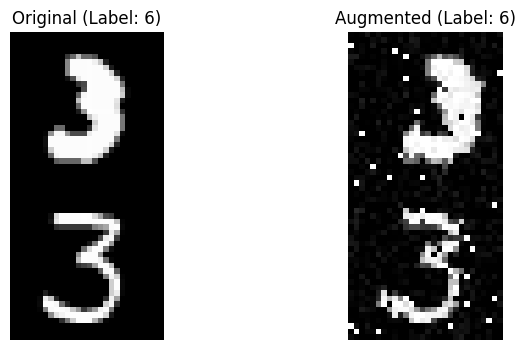

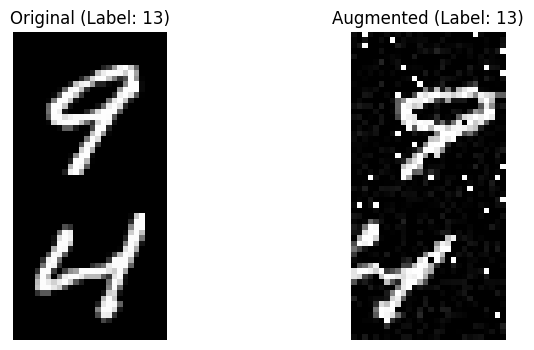

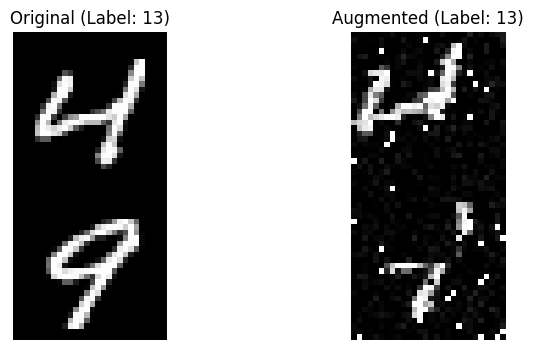

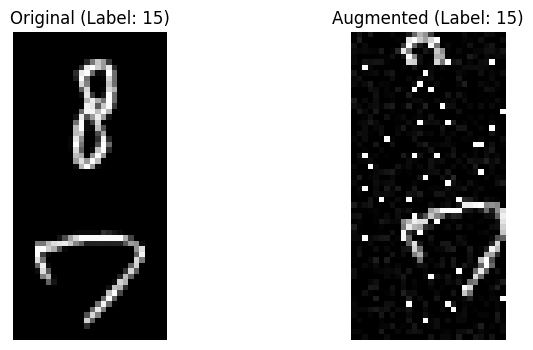

In [19]:
for i in range(1,5):
    show_images_side_by_side(i, combined_train_images, train_images, train_labels)

### Part III: Fully connected NN

In [22]:
# Fully connected NN Class

class FullyConnectedNN(nn.Module):
    """
    A fully connected neural network with a variable number of hidden layers.
    
    Args:
    input_size: int, number of input features
    hidden_size: int, number of hidden units
    num_classes: int, number of output classes
    num_hidden_layers: int, number of hidden layers
    activation: torch activation function, the activation function to use
    
    """
    def __init__(self, input_size, hidden_size, num_hidden_layers, activation, dropout_rate, decay_factor, num_classes=20):
        super(FullyConnectedNN, self).__init__()
        # Define the layers
        layers = []

        # Input layer
        current_size = hidden_size
        layers.append(nn.Linear(input_size, current_size))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for _ in range(num_hidden_layers-1):
            next_size = max(1, int(current_size*decay_factor))
            layers.append(nn.Linear(current_size, next_size))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))
            current_size = next_size

        # Output layer
        layers.append(nn.Linear(current_size, num_classes))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        # Define the forward pass
        x = x.view(x.size(0), -1)
        return self.layers(x)
    

    
# Instantiate the model
# model = FullyConnectedNN(input_size=1568, hidden_size=128, num_classes=20, num_hidden_layers=2, activation=nn.ReLU())

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Define the data loaders
# train_data = TensorDataset(train_images_tensor, train_labels_tensor)
# val_data = TensorDataset(val_images_tensor, val_labels_tensor)
# test_data = TensorDataset(test_images_tensor, test_labels_tensor)

# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [23]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    
    Args:
    model: nn.Module, the neural network model
    loader: torch DataLoader, the training data loader
    criterion: loss function
    optimizer: optimizer
    device: str, 'cpu' or 'cuda'
    
    Returns:
    epoch_loss: float, the average loss for the epoch
    epoch_accuracy: float, the accuracy for the epoch
    """
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        # Move data to the specified device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item() * images.size(0)  # Multiply by batch size
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

In [24]:
def validate(model, loader, criterion, device):
    """
    Validate the model

    Args:
    model: nn.Module, the neural network model
    loader: torch DataLoader, the validation data loader
    criterion: loss function
    device: str, 'cpu' or 'cuda'

    Returns:
    epoch_loss: float, the average loss for the epoch
    epoch_accuracy: float, the accuracy for the epoch
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update running loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy, all_preds, all_labels

In [25]:
# model = model.to(device)

# num_epochs = 10  # Set the number of epochs

# for epoch in range(num_epochs):
#     # Train for one epoch
#     train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

#     # Validate after training
#     val_loss, val_acc = validate(model, val_loader, criterion, device)

#     print(f"Epoch {epoch+1}/{num_epochs}")
#     print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
#     print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


In [26]:
# test_loss, test_acc = validate(model, test_loader, criterion, device)
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


In [27]:
# Tuning the hyperparameters

# Random search for hyperparameters

# hidden_sizes = [64, 128, 256]
# learning_rates = [0.001, 0.01, 0.1]
# hidden_layers = [1, 2, 3]
# batch_sizes = [32, 64, 128]
# activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
# dropout_rates = [0.1, 0.2, 0.3]

# tuning_trials = 10
# hyperparameters = []

# for _ in range(tuning_trials):
#     hs = random.choice(hidden_sizes)
#     lr = random.choice(learning_rates)
#     hl = random.choice(hidden_layers)
#     bs = random.choice(batch_sizes)
#     af = random.choice(activation_functions)
#     dr = random.choice(dropout_rates)
    
#     hyperparameters.append((lr, hl, hs, bs, af, dr))

In [28]:
# Grid search for hyperparameters

# hidden_sizes = [64, 128, 256]
# learning_rates = [0.001, 0.01, 0.1]
# hidden_layers = [1, 2, 3]
# batch_sizes = [32, 64, 128]
# activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.LeakyReLU()]
# dropout_rates = [0.1, 0.2, 0.3]

# hyperparameters = []

# for hs in hidden_sizes:
#     for lr in learning_rates:
#         for hl in hidden_layers:
#             for bs in batch_sizes:
#                 for af in activation_functions:
#                     for dr in dropout_rates:
#                         hyperparameters.append((lr, hl, hs, bs, af, dr))

In [29]:
# hyperparameters

In [30]:
def train_and_evaluate(lr, num_hidden_layers, hidden_size, batch_size, activation, dropout_rate, decay_factor, train_input, train_labels, val_input, val_labels, test_input, test_labels, optimiser = 'adam', no_epochs=3):
    """
    Master function to train and evaluate the model
    
    Args:
    lr: float, learning rate
    num_hidden_layers: int, number of hidden layers
    hidden_size: int, number of hidden units
    batch_size: int, batch size
    activation: str, activation function
    train_input: list of torch tensors, training input data
    train_labels: list of ints, training labels
    val_input: list of torch tensors, validation input data
    val_labels: list of ints, validation labels
    test_input: list of torch tensors, test input data
    test_labels: list of ints, test labels
    no_epochs: int, number of epochs
    optimiser: str, 'adam', 'sgd', or 'rmsprop'
    
    Returns:
    val_loss: float, validation loss
    val_acc: float, validation accuracy
    test_loss: float, test loss
    test_acc: float, test accuracy
    train_loss: float, train loss
    train_acc: float, train accuracy
    train_loss_list: list of floats, training loss for each epoch
    val_loss_list: list of floats, validation loss for each epoch
    model: nn.Module, trained model
    """
    # Initialize the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = FullyConnectedNN(
        input_size=1568,
        hidden_size=hidden_size,
        num_hidden_layers=num_hidden_layers,
        activation=activation,
        dropout_rate=dropout_rate,
        decay_factor=decay_factor,
        num_classes=20,
    ).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimiser == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimiser == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimiser == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # Stack the train and label sets
    train_data_stacked = torch.stack(train_input)
    train_labels_stacked = torch.tensor(train_labels)

    val_data_stacked = torch.stack(val_input)
    val_labels_stacked = torch.tensor(val_labels)

    test_data_stacked = torch.stack(test_input)
    test_labels_stacked = torch.tensor(test_labels)

    # Combine data and labels into TensorDataset
    train_tensor = TensorDataset(train_data_stacked, train_labels_stacked)
    val_tensor = TensorDataset(val_data_stacked, val_labels_stacked)
    test_tensor = TensorDataset(test_data_stacked, test_labels_stacked)

    # Create data loaders
    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)


    # Train the model
    train_loss_list = []
    val_loss_list = []

    train_acc_list = []
    val_acc_list = []
    for epoch in range(no_epochs):  # Keep epochs small for quick tuning
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _,_ = validate(model, val_loader, criterion, device)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f"Epoch {epoch+1}/{no_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    test_loss, test_acc, all_preds, all_labels = validate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list, all_preds, all_labels, model



In [32]:
train_and_evaluate(0.001, 3, 128, 32, nn.ReLU(), 0.3, 0.5, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', 10)

Epoch 1/10
  Train Loss: 2.6133, Train Accuracy: 0.1261
  Val Loss: 1.9441, Val Accuracy: 0.3326
Epoch 2/10
  Train Loss: 2.3734, Train Accuracy: 0.2042
  Val Loss: 1.5400, Val Accuracy: 0.5049
Epoch 3/10
  Train Loss: 2.2465, Train Accuracy: 0.2603
  Val Loss: 1.2468, Val Accuracy: 0.6547
Epoch 4/10
  Train Loss: 2.1530, Train Accuracy: 0.3004
  Val Loss: 1.0706, Val Accuracy: 0.7189
Epoch 5/10
  Train Loss: 2.0869, Train Accuracy: 0.3283
  Val Loss: 0.9221, Val Accuracy: 0.7551
Epoch 6/10
  Train Loss: 2.0355, Train Accuracy: 0.3474
  Val Loss: 0.8558, Val Accuracy: 0.7706
Epoch 7/10
  Train Loss: 2.0047, Train Accuracy: 0.3586
  Val Loss: 0.7919, Val Accuracy: 0.7939
Epoch 8/10
  Train Loss: 1.9840, Train Accuracy: 0.3671
  Val Loss: 0.7778, Val Accuracy: 0.8019
Epoch 9/10
  Train Loss: 1.9615, Train Accuracy: 0.3745
  Val Loss: 0.7318, Val Accuracy: 0.8082
Epoch 10/10
  Train Loss: 1.9398, Train Accuracy: 0.3827
  Val Loss: 0.7028, Val Accuracy: 0.8194
Test Loss: 0.6776, Test Accur

(0.7028417850221906,
 0.8194285714285714,
 0.6775902827467237,
 0.8219285714285715,
 1.9397800258000693,
 0.38270238095238096,
 [2.6132565453847247,
  2.373371193749564,
  2.246472588675363,
  2.1530212928227015,
  2.0868805023829142,
  2.03548317305247,
  2.004664286976769,
  1.9840022335960752,
  1.9614739924839564,
  1.9397800258000693],
 [1.94408797454834,
  1.5399606594358173,
  1.2467980515616282,
  1.0705857576642717,
  0.9220529789243426,
  0.8557861684731075,
  0.7918983186313084,
  0.7778294790472303,
  0.7317957756859915,
  0.7028417850221906],
 [0.12607142857142858,
  0.20416666666666666,
  0.26029761904761906,
  0.3004047619047619,
  0.3283452380952381,
  0.34741666666666665,
  0.35860714285714285,
  0.3671190476190476,
  0.37448809523809523,
  0.38270238095238096],
 [0.3325714285714286,
  0.5048571428571429,
  0.6547142857142857,
  0.7188571428571429,
  0.7550714285714286,
  0.7705714285714286,
  0.7939285714285714,
  0.8019285714285714,
  0.8082142857142857,
  0.81942857

In [31]:
# results = []
# for lr, num_hidden_layers, hidden_size, batch_size, activation, dropout_rate in hyperparameters:
#     val_loss, val_acc, test_loss, test_acc, model = train_and_evaluate(lr, num_hidden_layers, hidden_size, batch_size, activation, dropout_rate, train_images, train_labels, val_images, val_labels, test_images, test_labels, 10)
#     results.append((lr, num_hidden_layers, hidden_size, batch_size, activation, dropout_rate, val_loss, val_acc, test_loss, test_acc))
#     print(f"LR: {lr}, Layers: {num_hidden_layers}, Hidden: {hidden_size}, Batch: {batch_size}, Activation: {activation}, Dropout Rate: {dropout_rate}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

### Part IV: Optimising hyperparameters for the FCNN using Optuna

In [89]:
def objective(trial):
    """
    Objective function for Optuna to optimize
    
    Args:
    trial: optuna.trial.Trial, a trial object
    
    Returns:
    val_acc: float, validation accuracy
    """
    lr = trial.suggest_float('lr', 0.0001, 0.001, log=True)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 15)
    hidden_size = trial.suggest_int('hidden_size', 128, 1024)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    activation_class = trial.suggest_categorical('activation_class', ['ReLU', 'Sigmoid', 'Tanh', 'LeakyReLU'])
    activation = getattr(nn, activation_class)()
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    decay_factor = trial.suggest_float('decay_factor', 0.1, 0.9)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = FullyConnectedNN(
        input_size=1568,
        hidden_size=hidden_size,
        num_hidden_layers=num_hidden_layers,
        activation=activation,
        dropout_rate=dropout_rate,
        decay_factor=decay_factor,
        num_classes=20,
    ).to(device)

    if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    criterion = nn.CrossEntropyLoss()

    # Data loaders
    train_data_stacked = torch.stack(combined_train_images)
    train_labels_stacked = torch.tensor(combined_train_labels)

    val_data_stacked = torch.stack(val_images)
    val_labels_stacked = torch.tensor(val_labels)

    train_tensor = TensorDataset(train_data_stacked, train_labels_stacked)
    val_tensor = TensorDataset(val_data_stacked, val_labels_stacked)

    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)

    for epoch in range(3):
        _, _ = train_one_epoch(model, train_loader, criterion, optimizer, device)
        _, val_acc, _ ,_ = validate(model, val_loader, criterion, device)
    
    return val_acc

In [90]:
def FCNN_optimised(n_trials = 10, no_epochs = 10, optimisation_required = False):
    """
    Function to optimise the hyperparameters of the Fully Connected Neural Network

    Args:
    n_trials: int, number of trials for the hyperparameter optimisation
    no_epochs: int, number of epochs for training
    optimiser: str, 'adam', 'sgd', or 'rmsprop'
    optimisation_required: bool, whether to perform hyperparameter optimisation

    Returns:
    val_loss: float, validation loss
    val_acc: float, validation accuracy
    test_loss: float, test loss
    test_acc: float, test accuracy
    train_loss: float, train loss
    train_acc: float, train accuracy
    train_loss_list: list of floats, training loss for each epoch
    val_loss_list: list of floats, validation loss for each epoch
    model: nn.Module, trained model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if optimisation_required:
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)

        print(f'Best hyperparameters: {study.best_params}')
        print(f'Best validation accuracy{study.best_value}')

        best_lr = study.best_params['lr']
        best_num_hidden_layers = study.best_params['num_hidden_layers']
        best_hidden_size = study.best_params['hidden_size']
        best_batch_size = study.best_params['batch_size']
        best_activation_class = study.best_params['activation_class']  # Get the string stored in best_params
        best_activation = getattr(nn, best_activation_class)()
        best_dropout_rate = study.best_params['dropout_rate']
        best_decay_factor = study.best_params['decay_factor']
        best_optimizer = study.best_params['optimizer']

        model = FullyConnectedNN(
            input_size=1568,
            hidden_size=best_hidden_size,
            num_hidden_layers=best_num_hidden_layers,
            activation=best_activation,
            dropout_rate=best_dropout_rate,
            decay_factor=best_decay_factor,
            num_classes=20,
        ).to(device)

        torch.save({
            'model_state_dict': model.state_dict(),
            'hyperparameters': study.best_params,  # Save the best_params directly
            'input_size': 1568  # If this is constant, you can include it separately
        }, "best_model_with_params.pth")
    
    else:
        try:
            checkpoint = torch.load('best_model_with_params.pth')
        except FileNotFoundError:
            print('No checkpoint found. Please run the function with optimisation_required=True first')
        except KeyError:
            print('No hyperparameters found in the checkpoint. Please run the function with optimisation_required=True first')
        
        best_params = checkpoint['hyperparameters']

        best_activation_class = best_params['activation_class']
        best_activation = getattr(nn, best_activation_class)()

        best_lr = best_params['lr']
        best_num_hidden_layers = best_params['num_hidden_layers']
        best_hidden_size = best_params['hidden_size']
        best_batch_size = best_params['batch_size']
        best_dropout_rate = best_params['dropout_rate']
        best_decay_factor = best_params['decay_factor']
        best_optimizer = best_params['optimizer']

        model = FullyConnectedNN(
            input_size=1568,
            hidden_size=best_hidden_size,
            num_hidden_layers=best_num_hidden_layers,
            activation=best_activation,
            dropout_rate=best_dropout_rate,
            decay_factor=best_decay_factor,
            num_classes=20,
        ).to(device)

    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, all_preds, all_labels, model = train_and_evaluate(best_lr, best_num_hidden_layers, best_hidden_size, best_batch_size, best_activation, best_dropout_rate, best_decay_factor, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, best_optimizer, no_epochs)
 
    return val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, all_preds, all_labels, model


Runs optimal NN and plots some neurons

In [91]:
val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, all_preds, all_labels, model = FCNN_optimised(2, 2, True)
# visualise_weights(model)

[I 2024-11-19 13:08:31,264] A new study created in memory with name: no-name-72596f6f-12c9-4867-9667-a3fa4f1d0ace
[I 2024-11-19 13:08:55,787] Trial 0 finished with value: 0.08328571428571428 and parameters: {'lr': 0.00023179781298535875, 'num_hidden_layers': 11, 'hidden_size': 461, 'batch_size': 128, 'activation_class': 'ReLU', 'dropout_rate': 0.3983430359407848, 'decay_factor': 0.10602983957417998, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.08328571428571428.
[I 2024-11-19 13:09:54,398] Trial 1 finished with value: 0.08328571428571428 and parameters: {'lr': 0.0006409586458390922, 'num_hidden_layers': 14, 'hidden_size': 693, 'batch_size': 128, 'activation_class': 'Tanh', 'dropout_rate': 0.2622204639367565, 'decay_factor': 0.6363014365671689, 'optimizer': 'adam'}. Best is trial 0 with value: 0.08328571428571428.


Best hyperparameters: {'lr': 0.00023179781298535875, 'num_hidden_layers': 11, 'hidden_size': 461, 'batch_size': 128, 'activation_class': 'ReLU', 'dropout_rate': 0.3983430359407848, 'decay_factor': 0.10602983957417998, 'optimizer': 'rmsprop'}
Best validation accuracy0.08328571428571428
Epoch 1/2
  Train Loss: 3.1242, Train Accuracy: 0.0222
  Val Loss: 3.0741, Val Accuracy: 0.0224
Epoch 2/2
  Train Loss: 3.0549, Train Accuracy: 0.0693
  Val Loss: 3.0165, Val Accuracy: 0.0900
Test Loss: 3.0195, Test Accuracy: 0.0867


In [34]:
# Train the model with the best hyperparameters

# best_lr = study.best_params['lr']
# best_num_hidden_layers = study.best_params['num_hidden_layers']
# best_hidden_size = study.best_params['hidden_size']
# best_batch_size = study.best_params['batch_size']
# best_activation_class = study.best_params['activation_class']
# best_activation = getattr(nn, best_activation_class)()
# best_dropout_rate = study.best_params['dropout_rate']
# best_decay_factor = study.best_params['decay_factor']

# val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(best_lr, best_num_hidden_layers, best_hidden_size, best_batch_size, best_activation, best_dropout_rate, best_decay_factor, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', 10)
# torch.save(model.state_dict(), 'best_model.pth')

In [35]:
# Visualize the weights of the first layer
def visualise_weights(model):
    """
    Visualize the weights of the first layer of the model
    
    Args:
    model: nn.Module, the model
    """
    weights = model.layers[0].weight.data.cpu().numpy()
    for i in range(min(10, weights.shape[0])):  # Visualize up to 10 neurons
        plt.subplot(2, 5, i + 1)
        plt.imshow(weights[i].reshape(56, 28), cmap='viridis')  # Adjust reshape for proper visualization
        plt.title(f"Neuron {i+1}")
        plt.axis('off')
    plt.show()

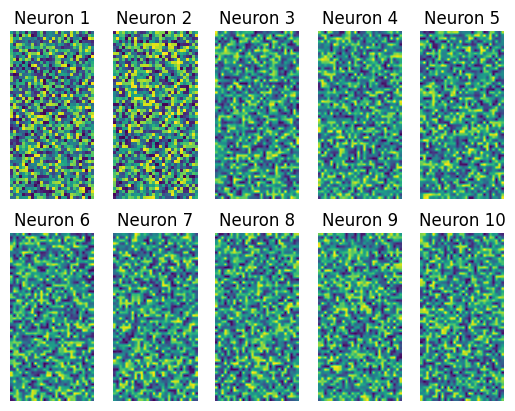

In [92]:
visualise_weights(model)

### Part V: Analysis (plots)

In [66]:
# Ultimate model

epochs = 20
val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, cm1, cm2, model = FCNN_optimised(20, epochs)

KeyboardInterrupt: 

In [94]:
checkpoint = torch.load('best_model_with_params.pth')
best_params = checkpoint['hyperparameters']

print(best_params['lr'])
print(best_params['num_hidden_layers'])
print(best_params['hidden_size'])
print(best_params['batch_size'])
print(best_params['activation_class'])
print(best_params['dropout_rate'])
print(best_params['decay_factor'])
print(getattr(nn, best_params['activation_class'])())
print(best_params['optimizer'])


0.00023179781298535875
11
461
128
ReLU
0.3983430359407848
0.10602983957417998
ReLU()
rmsprop


In [71]:

# Running FCNN using optimised hyperparameters across 20 epochs using the rmsprop optimiser
val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list_rmsprop, val_list_rmsprop, train_acc_list_rmsprop, val_acc_list_rmsprop, all_preds, all_labels, model = FCNN_optimised(20, epochs, 'rmsprop', False)

# Running FCNN using optimised hyperparameters across 20 epochs using the sgd optimiser
val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list_sgd, val_list_sgd, train_acc_list_sgd, val_acc_list_sgd, all_preds, all_labels, model = FCNN_optimised(20, epochs, 'sgd', False)
                                                                                                                         


Epoch 1/20
  Train Loss: 2.2671, Train Accuracy: 0.2546
  Val Loss: 0.8159, Val Accuracy: 0.7579
Epoch 2/20
  Train Loss: 1.7212, Train Accuracy: 0.4502
  Val Loss: 0.5638, Val Accuracy: 0.8404
Epoch 3/20
  Train Loss: 1.6068, Train Accuracy: 0.4853
  Val Loss: 0.4965, Val Accuracy: 0.8691
Epoch 4/20
  Train Loss: 1.5404, Train Accuracy: 0.5031
  Val Loss: 0.4472, Val Accuracy: 0.8819
Epoch 5/20
  Train Loss: 1.5026, Train Accuracy: 0.5154
  Val Loss: 0.4328, Val Accuracy: 0.8902
Epoch 6/20
  Train Loss: 1.4731, Train Accuracy: 0.5251
  Val Loss: 0.4139, Val Accuracy: 0.8983
Epoch 7/20
  Train Loss: 1.4502, Train Accuracy: 0.5315
  Val Loss: 0.4534, Val Accuracy: 0.8944
Epoch 8/20
  Train Loss: 1.4367, Train Accuracy: 0.5366
  Val Loss: 0.4582, Val Accuracy: 0.8985
Epoch 9/20
  Train Loss: 1.4209, Train Accuracy: 0.5412
  Val Loss: 0.4419, Val Accuracy: 0.9068
Epoch 10/20
  Train Loss: 1.4125, Train Accuracy: 0.5459
  Val Loss: 0.4481, Val Accuracy: 0.9085
Epoch 11/20
  Train Loss: 1.4

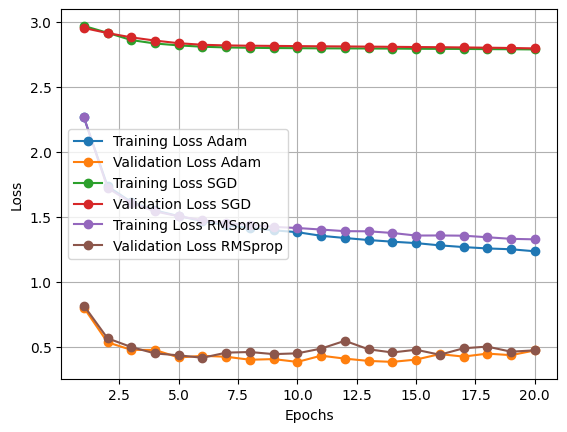

In [72]:

plt.plot(range(1,epochs+1), train_list, label="Training Loss Adam", marker='o')
plt.plot(range(1,epochs+1), val_list, label="Validation Loss Adam", marker='o')
plt.plot(range(1,epochs+1), train_list_sgd, label="Training Loss SGD", marker='o')
plt.plot(range(1,epochs+1), val_list_sgd, label="Validation Loss SGD", marker='o')
plt.plot(range(1,epochs+1), train_list_rmsprop, label="Training Loss RMSprop", marker='o')
plt.plot(range(1,epochs+1), val_list_rmsprop, label="Validation Loss RMSprop", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

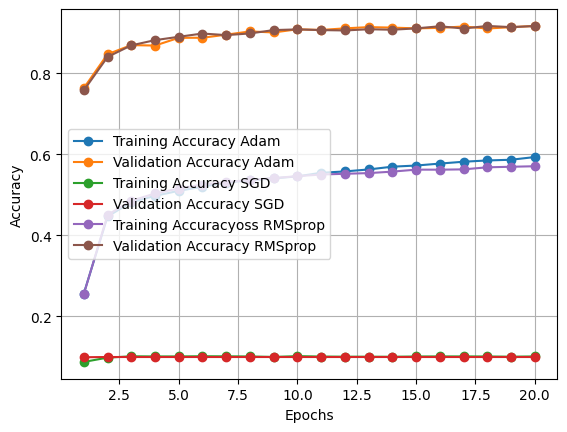

In [75]:
# Visualize the training and validation accuracy


plt.plot(range(1,epochs+1), train_acc_list, label="Training Accuracy Adam", marker='o')
plt.plot(range(1,epochs+1), val_acc_list, label="Validation Accuracy Adam", marker='o')
plt.plot(range(1,epochs+1), train_acc_list_sgd, label="Training Accuracy SGD", marker='o')
plt.plot(range(1,epochs+1), val_acc_list_sgd, label="Validation Accuracy SGD", marker='o')
plt.plot(range(1,epochs+1), train_acc_list_rmsprop, label="Training Accuracyoss RMSprop", marker='o')
plt.plot(range(1,epochs+1), val_acc_list_rmsprop, label="Validation Accuracy RMSprop", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Plot surface of validation loss against depth and width of NN

learning_rate_base = 0.001
batch_size_base = 64
activation_base = nn.ReLU()
dropout_rate_base = 0.2
no_epochs = 20
decay_factor_base = 0.8

num_hidden_layers = np.arange(1, 20)
hidden_sizes = np.arange(64, 1024, 50)

results = []

for num_hidden_layer in num_hidden_layers:
    for hidden_size in hidden_sizes:
        val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layer, hidden_size, batch_size_base, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
        print(f"Layers: {num_hidden_layer}, Hidden: {hidden_size}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        results.append((num_hidden_layer, hidden_size, val_loss))
        print(f"Layers: {num_hidden_layer}, Hidden: {hidden_size}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")



Epoch 1/20
  Train Loss: 2.4874, Train Accuracy: 0.1877
  Val Loss: 1.6632, Val Accuracy: 0.4782
Epoch 2/20
  Train Loss: 2.1874, Train Accuracy: 0.2897
  Val Loss: 1.3209, Val Accuracy: 0.6014
Epoch 3/20
  Train Loss: 2.0780, Train Accuracy: 0.3238
  Val Loss: 1.1895, Val Accuracy: 0.6357
Epoch 4/20
  Train Loss: 2.0135, Train Accuracy: 0.3459
  Val Loss: 1.0954, Val Accuracy: 0.6687
Epoch 5/20
  Train Loss: 1.9694, Train Accuracy: 0.3599
  Val Loss: 1.0386, Val Accuracy: 0.6894
Epoch 6/20
  Train Loss: 1.9382, Train Accuracy: 0.3684
  Val Loss: 1.0063, Val Accuracy: 0.6953
Epoch 7/20
  Train Loss: 1.9166, Train Accuracy: 0.3763
  Val Loss: 0.9842, Val Accuracy: 0.6985
Epoch 8/20
  Train Loss: 1.8936, Train Accuracy: 0.3816
  Val Loss: 0.9521, Val Accuracy: 0.7130
Epoch 9/20
  Train Loss: 1.8793, Train Accuracy: 0.3862
  Val Loss: 0.9492, Val Accuracy: 0.7108
Epoch 10/20
  Train Loss: 1.8618, Train Accuracy: 0.3924
  Val Loss: 0.9475, Val Accuracy: 0.7114
Epoch 11/20
  Train Loss: 1.8

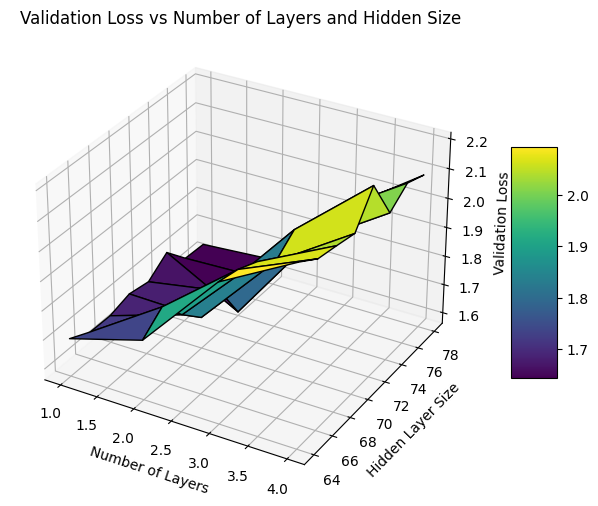

In [62]:
layers = np.array([r[0] for r in results])      # Number of layers (x-axis)
hidden_sizes = np.array([r[1] for r in results]) # Hidden size (y-axis)
val_losses = np.array([r[2] for r in results])   # Validation loss (z-axis)

# Reshape for plotting (if needed)
layers_grid = layers.reshape(len(num_hidden_layers), int(len(hidden_sizes)//len(num_hidden_layers)))
hidden_sizes_grid = hidden_sizes.reshape(len(num_hidden_layers), int(len(hidden_sizes)//len(num_hidden_layers)))
val_losses_grid = val_losses.reshape(len(num_hidden_layers), int(len(hidden_sizes)//len(num_hidden_layers)))


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(layers_grid, hidden_sizes_grid, val_losses_grid, cmap='viridis', edgecolor='k')

# Add labels
ax.set_xlabel("Number of Layers")
ax.set_ylabel("Hidden Layer Size")
ax.set_zlabel("Validation Loss")
ax.set_title("Validation Loss vs Number of Layers and Hidden Size")

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()



In [56]:
len(num_hidden_layers)

2

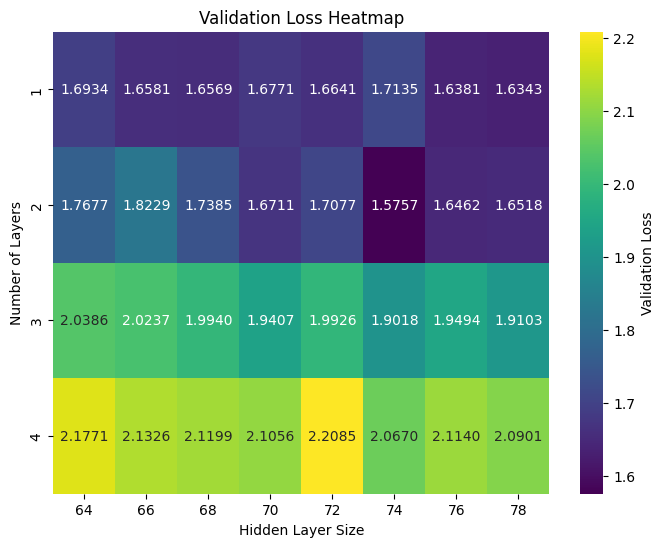

In [63]:
# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=["num_hidden_layers", "hidden_size", "val_loss"])

# Pivot the DataFrame to create the heatmap-compatible format
heatmap_data = results_df.pivot(index="num_hidden_layers", columns="hidden_size", values="val_loss")



plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Validation Loss'})

# Add labels and title
plt.title("Validation Loss Heatmap")
plt.xlabel("Hidden Layer Size")
plt.ylabel("Number of Layers")
plt.show()

In [64]:
# Dropout rate against loss

learning_rate_base = 0.001
batch_size_base = 64
activation_base = nn.ReLU()
dropout_rate_base = 0.2
no_epochs = 20
num_hidden_layers_base = 5
hidden_size_base = 512
decay_factor_base = 0.8
dropout_rates = np.linspace(0, 0.9, 101)

# activation function

val_losses_relu = []
train_losses_relu = []

val_losses_sigmoid = []
train_losses_sigmoid = []

for dropout_rate in dropout_rates:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
    val_losses_relu.append(val_loss)
    train_losses_relu.append(train_loss)
    print(f"Dropout Rate: {dropout_rate}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

activation_base = nn.Tanh()

for dropout_rate in dropout_rates:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
    val_losses_sigmoid.append(val_loss)
    train_losses_sigmoid.append(train_loss)
    print(f"Dropout Rate: {dropout_rate}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/1
  Train Loss: 2.4074, Train Accuracy: 0.1877
  Val Loss: 1.1891, Val Accuracy: 0.6094
Test Loss: 1.1808, Test Accuracy: 0.6130
Dropout Rate: 0.0, Val Loss: 1.1891, Val Acc: 0.6094, Test Loss: 1.1808, Test Acc: 0.6130
Epoch 1/1
  Train Loss: 2.3879, Train Accuracy: 0.1969
  Val Loss: 1.1937, Val Accuracy: 0.5972
Test Loss: 1.1698, Test Accuracy: 0.6047
Dropout Rate: 0.009000000000000001, Val Loss: 1.1937, Val Acc: 0.5972, Test Loss: 1.1698, Test Acc: 0.6047


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (101,) and (2,)

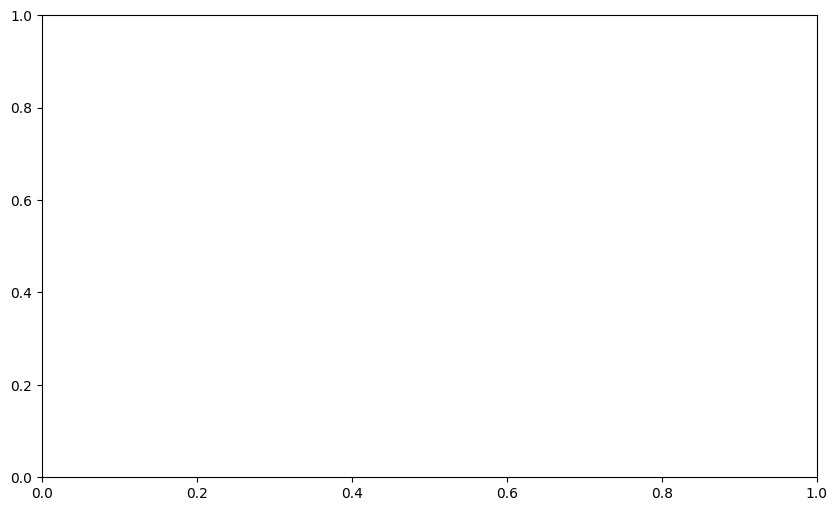

In [65]:


# Plot for ReLU
plt.figure(figsize=(10, 6))
plt.plot(dropout_rates, train_losses_relu, marker='o', label="Train Loss (ReLU)")
plt.plot(dropout_rates, val_losses_relu, marker='o', label="Validation Loss (ReLU)")

# Plot for Tanh
plt.plot(dropout_rates, train_losses_sigmoid, marker='s', label="Train Loss (Tanh)")
plt.plot(dropout_rates, val_losses_sigmoid, marker='s', label="Validation Loss (Tanh)")

# Labels and Title
plt.xlabel("Dropout Rate")
plt.ylabel("Loss")
plt.title("Effect of Dropout Rate on Loss (ReLU vs Tanh)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# learning rate against loss for various optimisers

learning_rate = np.linspace(0.0001, 0.01, 100)
batch_size_base = 64
activation_base = nn.ReLU()
optimisers = ['adam', 'sgd', 'rmsprop']
dropout_rate_base = 0.2
no_epochs = 20
num_hidden_layers_base = 5
hidden_size_base = 512
decay_factor_base = 0.8

val_losses_adam = []
train_losses_adam = []

val_losses_sgd = []
train_losses_sgd = []

val_losses_rmsprop = []
train_losses_rmsprop = []

for lr in learning_rate:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(lr, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'rmsprop', no_epochs)
    val_losses_rmsprop.append(val_loss)
    train_losses_rmsprop.append(train_loss)
    print(f"Learning Rate: {lr}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

for lr in learning_rate:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(lr, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
    val_losses_adam.append(val_loss)
    train_losses_adam.append(train_loss)
    print(f"Learning Rate: {lr}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

for lr in learning_rate:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(lr, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'sgd', no_epochs)
    val_losses_sgd.append(val_loss)
    train_losses_sgd.append(train_loss)
    print(f"Learning Rate: {lr}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")




In [ ]:


# Plot for ReLU
plt.figure(figsize=(10, 6))
plt.plot(learning_rate, train_losses_adam, marker='o', label="Train Loss (Adam)")
plt.plot(learning_rate, val_losses_adam, marker='o', label="Validation Loss (Adam)")

# Plot for Tanh
plt.plot(learning_rate, train_losses_sgd, marker='s', label="Train Loss (SGD)")
plt.plot(learning_rate, val_losses_sgd, marker='s', label="Validation Loss (SGD)")

# RMSprop
plt.plot(learning_rate, train_losses_rmsprop, marker='s', label="Train Loss (RMSprop)")
plt.plot(learning_rate, val_losses_rmsprop, marker='s', label="Validation Loss (RMSprop)")

# Labels and Title
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Effect of Learning Rate on Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# confusion matrix

# run = train_and_evaluate(0.001, 3, 128, 32, nn.ReLU(), 0.3, 0.8, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', 5)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       131
           1       0.95      0.96      0.95       322
           2       0.91      0.95      0.93       413
           3       0.93      0.96      0.95       601
           4       0.92      0.93      0.93       709
           5       0.92      0.94      0.93       849
           6       0.93      0.92      0.92      1100
           7       0.94      0.93      0.94      1074
           8       0.93      0.92      0.93      1252
           9       0.92      0.93      0.93      1374
          10       0.92      0.91      0.91      1218
          11       0.90      0.90      0.90      1060
          12       0.91      0.91      0.91       950
          13       0.92      0.90      0.91       846
          14       0.91      0.91      0.91       702
          15       0.93      0.91      0.92       594
          16       0.88      0.92      0.90       429
          17       0.90    

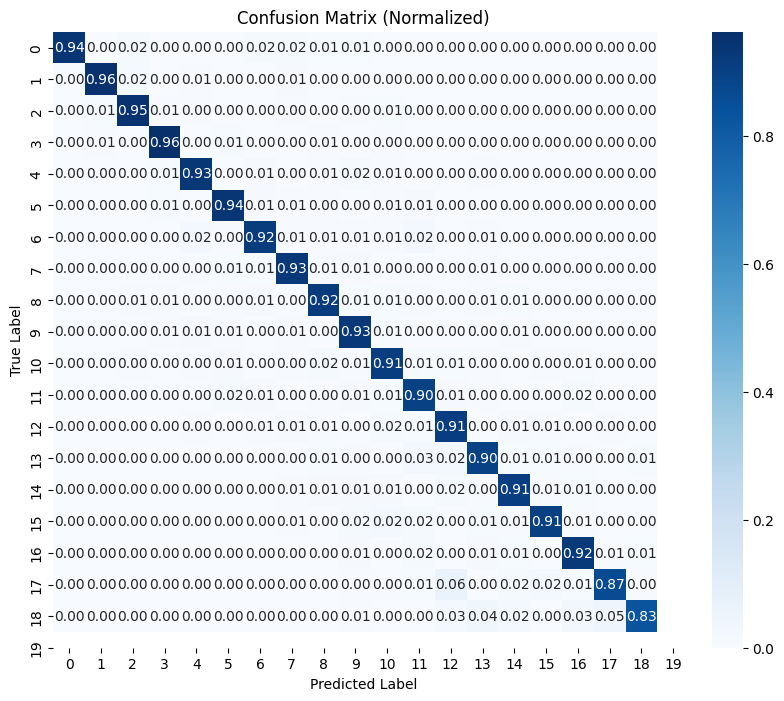

In [47]:


cm = confusion_matrix(cm1, cm2)

print(classification_report(cm1, cm2))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(20), yticklabels=range(20))

# Add labels and title
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [76]:
# Loss against decay factor

learning_rate_base = 0.001
batch_size_base = 64
activation_base = nn.ReLU()
optimisers = ['adam', 'sgd', 'rmsprop']
dropout_rate_base = 0.2
no_epochs = 1
num_hidden_layers_base = 5
hidden_size_base = 512
decay_factor_base = np.linspace(0, 0.9, 2)

val_losses_adam = []
train_losses_adam = []

val_losses_sgd = []
train_losses_sgd = []

val_losses_rmsprop = []
train_losses_rmsprop = []

for decay_factor in decay_factor_base:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'rmsprop', no_epochs)
    val_losses_rmsprop.append(val_loss)
    train_losses_rmsprop.append(train_loss)
    print(f"Decay Factor: {decay_factor}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

for decay_factor in decay_factor_base:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
    val_losses_adam.append(val_loss)
    train_losses_adam.append(train_loss)
    print(f"Decay Factor: {decay_factor}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

for decay_factor in decay_factor_base:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'sgd', no_epochs)
    val_losses_sgd.append(val_loss)
    train_losses_sgd.append(train_loss)
    print(f"Decay Factor: {decay_factor}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")





Epoch 1/1
  Train Loss: 2.8584, Train Accuracy: 0.0866
  Val Loss: 2.8142, Val Accuracy: 0.0833
Test Loss: 2.8030, Test Accuracy: 0.0883
Decay Factor: 0.0, Val Loss: 2.8142, Val Acc: 0.0833, Test Loss: 2.8030, Test Acc: 0.0883
Epoch 1/1
  Train Loss: 2.5293, Train Accuracy: 0.1629
  Val Loss: 1.4386, Val Accuracy: 0.5011
Test Loss: 1.4166, Test Accuracy: 0.5045
Decay Factor: 0.9, Val Loss: 1.4386, Val Acc: 0.5011, Test Loss: 1.4166, Test Acc: 0.5045
Epoch 1/1
  Train Loss: 2.9318, Train Accuracy: 0.0961
  Val Loss: 2.8317, Val Accuracy: 0.0991
Test Loss: 2.8219, Test Accuracy: 0.0990
Decay Factor: 0.0, Val Loss: 2.8317, Val Acc: 0.0991, Test Loss: 2.8219, Test Acc: 0.0990
Epoch 1/1
  Train Loss: 2.5176, Train Accuracy: 0.1537
  Val Loss: 1.5928, Val Accuracy: 0.4210
Test Loss: 1.5748, Test Accuracy: 0.4236
Decay Factor: 0.9, Val Loss: 1.5928, Val Acc: 0.4210, Test Loss: 1.5748, Test Acc: 0.4236
Epoch 1/1
  Train Loss: 2.9489, Train Accuracy: 0.0904
  Val Loss: 2.9538, Val Accuracy: 0.0

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

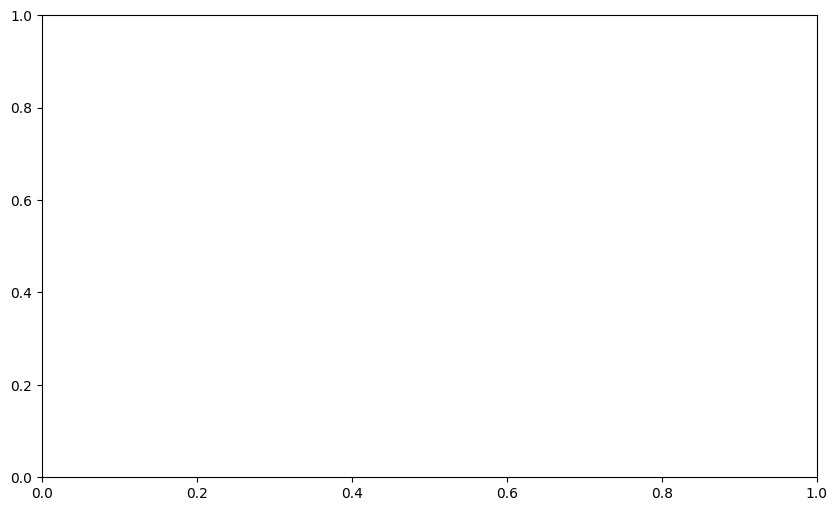

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(decay_factor_base, train_losses_adam, marker='o', label="Train Loss (Adam)")
plt.plot(decay_factor_base, val_losses_adam, marker='o', label="Validation Loss (Adam)")

plt.plot(decay_factor_base, train_losses_sgd, marker='s', label="Train Loss (SGD)")
plt.plot(decay_factor_base, val_losses_sgd, marker='s', label="Validation Loss (SGD)")

plt.plot(decay_factor_base, train_losses_rmsprop, marker='s', label="Train Loss (RMSprop)")
plt.plot(decay_factor_base, val_losses_rmsprop, marker='s', label="Validation Loss (RMSprop)")

# Labels and Title
plt.xlabel("Decay Factor")
plt.ylabel("Loss")
plt.title("Effect of Decay Rate on Loss")
plt.legend()
plt.grid(True)
plt.show()

In [79]:
# Batch size against learning rate


batch_size = [32, 64, 128, 256]
learning_rates = np.linspace(0.0001, 0.001, 4)


batch_size_base = 64
activation_base = nn.ReLU()
optimisers = 'adam'
dropout_rate_base = 0.2
no_epochs = 2
num_hidden_layers_base = 5
hidden_size_base = 512
decay_factor_base = 0.8


val_losses_bs_lr = []
train_losses_bs_lr = []

for batch in batch_size:
    for lr in learning_rates:
        val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(lr, num_hidden_layers_base, hidden_size_base, batch, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
        val_losses_bs_lr.append(val_loss)
        train_losses_bs_lr.append(train_loss)
        print(f"Batch Size: {batch}, Learning Rate: {lr}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/2
  Train Loss: 2.6462, Train Accuracy: 0.1181
  Val Loss: 2.1408, Val Accuracy: 0.2229
Epoch 2/2
  Train Loss: 2.3854, Train Accuracy: 0.1746
  Val Loss: 1.8113, Val Accuracy: 0.3220
Test Loss: 1.7975, Test Accuracy: 0.3276
Batch Size: 32, Learning Rate: 0.0001, Val Loss: 1.8113, Val Acc: 0.3220, Test Loss: 1.7975, Test Acc: 0.3276
Epoch 1/2
  Train Loss: 2.5135, Train Accuracy: 0.1492
  Val Loss: 1.7717, Val Accuracy: 0.3321
Epoch 2/2
  Train Loss: 2.0865, Train Accuracy: 0.3001
  Val Loss: 0.9001, Val Accuracy: 0.7369
Test Loss: 0.8912, Test Accuracy: 0.7366
Batch Size: 32, Learning Rate: 0.00039999999999999996, Val Loss: 0.9001, Val Acc: 0.7369, Test Loss: 0.8912, Test Acc: 0.7366
Epoch 1/2
  Train Loss: 2.4781, Train Accuracy: 0.1655
  Val Loss: 1.5128, Val Accuracy: 0.4642
Epoch 2/2
  Train Loss: 1.9703, Train Accuracy: 0.3624
  Val Loss: 0.6606, Val Accuracy: 0.8119
Test Loss: 0.6415, Test Accuracy: 0.8189
Batch Size: 32, Learning Rate: 0.0007, Val Loss: 0.6606, Val Acc:

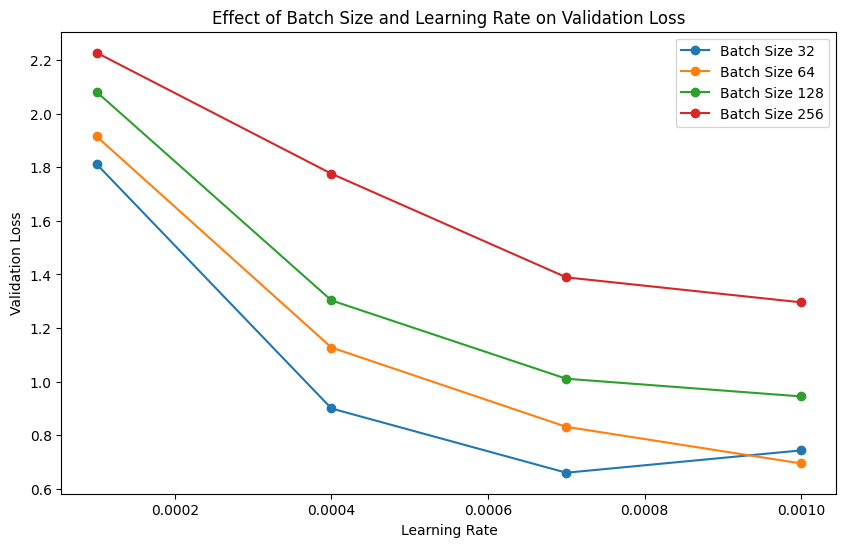

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, val_losses_bs_lr[:4], marker='o', label="Batch Size 32")
plt.plot(learning_rates, val_losses_bs_lr[4:8], marker='o', label="Batch Size 64")
plt.plot(learning_rates, val_losses_bs_lr[8:12], marker='o', label="Batch Size 128")
plt.plot(learning_rates, val_losses_bs_lr[12:], marker='o', label="Batch Size 256")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Loss")
plt.title("Effect of Batch Size and Learning Rate on Validation Loss")
plt.legend()


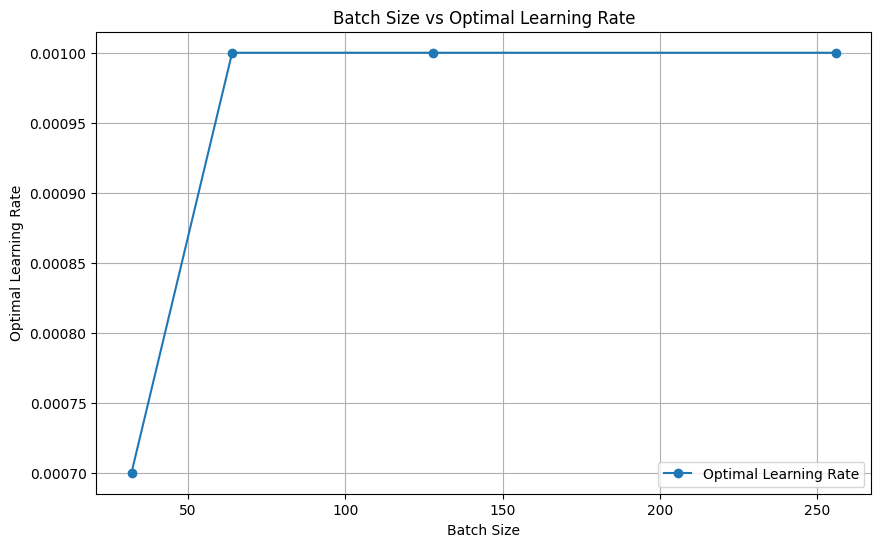

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Arrays to store the optimal learning rates
optimal_learning_rates = []
corresponding_batch_sizes = []

# Process validation losses to find optimal learning rates for each batch size
for i, batch in enumerate(batch_size):
    # Extract the validation losses for the current batch size
    batch_val_losses = val_losses_bs_lr[i * len(learning_rates):(i + 1) * len(learning_rates)]
    
    # Find the index of the minimum validation loss
    min_loss_index = np.argmin(batch_val_losses)
    
    # Store the optimal learning rate and corresponding batch size
    optimal_learning_rates.append(learning_rates[min_loss_index])
    corresponding_batch_sizes.append(batch)

# Plot the Batch Size vs Optimal Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(corresponding_batch_sizes, optimal_learning_rates, marker='o', label='Optimal Learning Rate')
plt.xlabel("Batch Size")
plt.ylabel("Optimal Learning Rate")
plt.title("Batch Size vs Optimal Learning Rate")
plt.grid(True)
plt.legend()
plt.show()


### Part V: Alternative Classifiers

Random Classifier

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [98]:
train_X = torch.stack(combined_train_images).view(len(combined_train_images), -1).numpy()
train_y = np.array(combined_train_labels)

val_X = torch.stack(val_images).view(len(val_images), -1).numpy()
val_y = np.array(val_labels)

test_X = torch.stack(test_images).view(len(test_images), -1).numpy()
test_y = np.array(test_labels)

In [100]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((84000, 1568), (84000,))

In [116]:
def train_and_evaluate_rf(train_X, train_y, val_X, val_y, test_X, test_y):
    """
    Train and evaluate a Random Forest classifier
    
    Args:
    train_X: np.ndarray, training data
    train_y: np.ndarray, training labels
    val_X: np.ndarray, validation data
    val_y: np.ndarray, validation labels
    test_X: np.ndarray, test data
    test_y: np.ndarray, test labels
    
    Returns:
    val_acc_rf: float, validation accuracy
    test_acc_rf: float, test accuracy
    """
    # Instantiate and train Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees
    rf_clf.fit(train_X, train_y)
    
    # Evaluate on validation and test sets
    val_preds_rf = rf_clf.predict(val_X)
    test_preds_rf = rf_clf.predict(test_X)
    
    val_acc_rf = accuracy_score(val_y, val_preds_rf)
    test_acc_rf = accuracy_score(test_y, test_preds_rf)
    
    print(f"Random Forest - Validation Accuracy: {val_acc_rf:.4f}, Test Accuracy: {test_acc_rf:.4f}")
    
    return val_acc_rf, test_acc_rf


SVM

In [107]:
def train_and_evaluate_SVM(train_X, train_y, val_X, val_y, test_X, test_y):
    """
    Train and evaluate a Support Vector Machine classifier
    
    Args:
    train_X: np.ndarray, training data
    train_y: np.ndarray, training labels
    val_X: np.ndarray, validation data
    val_y: np.ndarray, validation labels
    test_X: np.ndarray, test data
    test_y: np.ndarray, test labels
    
    Returns:
    val_acc_svm: float, validation accuracy
    test_acc_svm: float, test accuracy
    """
    # Instantiate and train Support Vector Machine Classifier
    svm_clf = SVC(kernel='rbf', random_state=42)
    svm_clf.fit(train_X, train_y)
    
    # Evaluate on validation and test sets
    val_preds_svm = svm_clf.predict(val_X)
    test_preds_svm = svm_clf.predict(test_X)
    
    val_acc_svm = accuracy_score(val_y, val_preds_svm)
    test_acc_svm = accuracy_score(test_y, test_preds_svm)
    
    print(f"SVM - Validation Accuracy: {val_acc_svm:.4f}, Test Accuracy: {test_acc_svm:.4f}")
    
    return val_acc_svm, test_acc_svm



Logistic Regressor

In [106]:
from sklearn.linear_model import LogisticRegression


def train_and_evaluate_lr(train_X, train_y, val_X, val_y, test_X, test_y):
    """
    Train and evaluate a Logistic Regression classifier
    
    Args:
    train_X: np.ndarray, training data
    train_y: np.ndarray, training labels
    val_X: np.ndarray, validation data
    val_y: np.ndarray, validation labels
    test_X: np.ndarray, test data
    test_y: np.ndarray, test labels
    
    Returns:
    val_acc_lr: float, validation accuracy
    test_acc_lr: float, test accuracy
    """
    # Instantiate and train Logistic Regression Classifier
    lr_clf = LogisticRegression(random_state=42, max_iter=1000)
    lr_clf.fit(train_X, train_y)
    
    # Evaluate on validation and test sets
    val_preds_lr = lr_clf.predict(val_X)
    test_preds_lr = lr_clf.predict(test_X)
    
    val_acc_lr = accuracy_score(val_y, val_preds_lr)
    test_acc_lr = accuracy_score(test_y, test_preds_lr)
    
    print(f"Logistic Regression - Validation Accuracy: {val_acc_lr:.4f}, Test Accuracy: {test_acc_lr:.4f}")
    
    return val_acc_lr, test_acc_lr


KNN

In [105]:
def train_and_evaluate_KNN(train_X, train_y, val_X, val_y, test_X, test_y):
    """
    Train and evaluate a K-Nearest Neighbors classifier
    
    Args:
    train_X: np.ndarray, training data
    train_y: np.ndarray, training labels
    val_X: np.ndarray, validation data
    val_y: np.ndarray, validation labels
    test_X: np.ndarray, test data
    test_y: np.ndarray, test labels
    
    Returns:
    val_acc_knn: float, validation accuracy
    test_acc_knn: float, test accuracy
    """
    # Instantiate and train K-Nearest Neighbors Classifier
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(train_X, train_y)
    
    # Evaluate on validation and test sets
    val_preds_knn = knn_clf.predict(val_X)
    test_preds_knn = knn_clf.predict(test_X)
    
    val_acc_knn = accuracy_score(val_y, val_preds_knn)
    test_acc_knn = accuracy_score(test_y, test_preds_knn)
    
    print(f"K-Nearest Neighbors - Validation Accuracy: {val_acc_knn:.4f}, Test Accuracy: {test_acc_knn:.4f}")
    
    return val_acc_knn, test_acc_knn

Gradient Boosting Classifier

In [108]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score


def train_and_evaluate_gb(train_X, train_y, val_X, val_y, test_X, test_y):
    """
    Train and evaluate a Gradient Boosting classifier
    
    Args:
    train_X: np.ndarray, training data
    train_y: np.ndarray, training labels
    val_X: np.ndarray, validation data
    val_y: np.ndarray, validation labels
    test_X: np.ndarray, test data
    test_y: np.ndarray, test labels
    
    Returns:
    val_acc_gb: float, validation accuracy
    test_acc_gb: float, test accuracy
    """
    # Instantiate and train Gradient Boosting Classifier
    gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_clf.fit(train_X, train_y)
    
    # Evaluate on validation and test sets
    val_preds_gb = gb_clf.predict(val_X)
    test_preds_gb = gb_clf.predict(test_X)
    
    val_acc_gb = accuracy_score(val_y, val_preds_gb)
    test_acc_gb = accuracy_score(test_y, test_preds_gb)
    
    print(f"Gradient Boosting - Validation Accuracy: {val_acc_gb:.4f}, Test Accuracy: {test_acc_gb:.4f}")
    
    return val_acc_gb, test_acc_gb


Objective functions for optuna to optimse on

In [117]:
# objective functions for rf, svm, lr, knn, gb

def objective_rf(trial):
    """
    Objective function for the Random Forest hyperparameter optimization
    
    Args:
    trial: optuna.Trial, a single optimization trial
    
    Returns:
    val_acc_rf: float, validation accuracy
    """
    # Hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    
    score = cross_val_score(model, train_X, train_y, cv=3, scoring='accuracy').mean()
    print(f"Random Forest - Validation Accuracy: {score:.4f}")
    return score




def objective_svm(trial):
    """
    Objective function for the Support Vector Machine hyperparameter optimization
    
    Args:
    trial: optuna.Trial, a single optimization trial
    
    Returns:
    val_acc_svm: float, validation accuracy
    """
    # Hyperparameters to optimize
    c_val = trial.suggest_float('C', 1e-3, 1e2, log=True)
    gamma = trial.suggest_float('gamma', 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])

    model = SVC(C=c_val, kernel=kernel, gamma=gamma, random_state=42)
    
    score = cross_val_score(model, train_X, train_y, cv=3, scoring='accuracy').mean()
    return score



def objective_lr(trial):
    """
    Objective function for the Logistic Regression hyperparameter optimization
    
    Args:
    trial: optuna.Trial, a single optimization trial
    
    Returns:
    val_acc_lr: float, validation accuracy
    """
    # Hyperparameters to optimize
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    model = LogisticRegression(max_iter=max_iter, random_state=42)
    
    score = cross_val_score(model, train_X, train_y, cv=3, scoring='accuracy').mean()
    return score


def objective_knn(trial):
    """
    Objective function for the K-Nearest Neighbors hyperparameter optimization
    
    Args:
    trial: optuna.Trial, a single optimization trial
    
    Returns:
    val_acc_knn: float, validation accuracy
    """
    # Hyperparameters to optimize
    n_neighbors = trial.suggest_int('n_neighbors', 3, 10)

    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    score = cross_val_score(model, train_X, train_y, cv=3, scoring='accuracy').mean()
    return score

def objective_gb(trial):
    """
    Objective function for the Gradient Boosting hyperparameter optimization
    
    Args:
    trial: optuna.Trial, a single optimization trial
    
    Returns:
    val_acc_gb: float, validation accuracy
    """
    # Hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e0)

    model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    
    score = cross_val_score(model, train_X, train_y, cv=3, scoring='accuracy').mean()
    return score


In [1]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)

NameError: name 'optuna' is not defined

Bar chart summarising performance and time differences